# MagPySV example workflow

# Setup

In [1]:
# Setup python paths and import some modules
from IPython.display import Image
import sys
sys.path.append('..')
import os
import datetime as dt

In [2]:
%matplotlib notebook

In [3]:
# Import all of the MagPySV modules
import magpysv.denoise as denoise
import magpysv.inputoutput as inputoutput
import magpysv.model_prediction as model_prediction
import magpysv.svplots as svplots
import magpysv.svtools as svtools

In [ ]:
stations = model_prediction.get_observatory_list()

# Residuals

Select a few observatories

In [4]:
obs_names = ['NGK']
fig_path = '/Users/gracecox/Desktop/DataDownloads/denoised_sv/test/test1/admm'

Concatenate the data for our selected observatories.

In [28]:
start = dt.datetime(1960, 1, 1)
end = dt.datetime(2010, 12, 31)
#start = dt.datetime(2000, 1, 1)
#end = dt.datetime(2010, 12, 31)
obs_data, model_sv_data, model_mf_data = inputoutput.combine_csv_data(
    start_date=start, end_date=end, obs_list=obs_names,
    data_path="/Users/gracecox/Desktop/DataDownloads/monthly_sv/fdmm/",
    model_path="/Users/gracecox/Dropbox/cov-obs_x1/monthly_vals/", day_of_month=1)

In [29]:
dates = obs_data['date']

# Outlier detection

Optionally remove spikes in the data before denoising. Large outliers can affect the denoising process so better to remove them beforehand for some series (i.e. at high latitude observatories).

In [ ]:
obs_data.drop(['date'], axis=1, inplace=True)
for column in obs_data:    
    obs_data[column] = denoise.detect_outliers(dates=dates, signal=obs_data[column], obs_name=column,
                                               threshold=2.5,
                                               window_length=72, plot_fig=False, save_fig=False,
                                               write_path='/Users/gracecox/Desktop/DataDownloads/denoised_sv/outliers/')
obs_data.insert(0, 'date', dates)

# External noise removal

Compute the residuals and use the eigenvalues/vectors of the covariance matrix to remove unmodelled external signal (Wardinski & Holme, 2011)

In [30]:
residuals = svtools.calculate_residuals(obs_data=obs_data, model_data=model_sv_data)

In [31]:
model_sv_data.drop(['date'], axis=1, inplace=True)
obs_data.drop(['date'], axis=1, inplace=True)

In [32]:
denoised, proxy, eigenvals, eigenvecs = denoise.eigenvalue_analysis(
    dates=dates, obs_data=obs_data, model_data=model_sv_data, residuals=residuals,
    proxy_number=1)

In [ ]:
print(eigenvecs, eigenvals)

# Denoised SV plots

Plots showing the original SV data, the denoised data (optionally with a running average) and the field model predictions.

In [ ]:
for observatory in obs_names:
    svplots.plot_sv_comparison(dates=dates, denoised_sv=denoised.filter(regex=observatory),
                               noisy_sv=obs_data.filter(regex=observatory), model=model_sv_data.filter(regex=observatory),
                    fig_size=(10, 10), font_size=14, label_size=20, plot_legend=True, obs=observatory,
                    plot_average=False, window_length=12, save_fig=True,
                               write_path=fig_path)

# Plot proxy signal, eigenvalues and eigenvectors

Compare the proxy signal used to denoise the data with the Dcx index (extended, corrected Dst index). Both signals are reduced to zero-mean and unit variance (z-score).

<IPython.core.display.Javascript object>


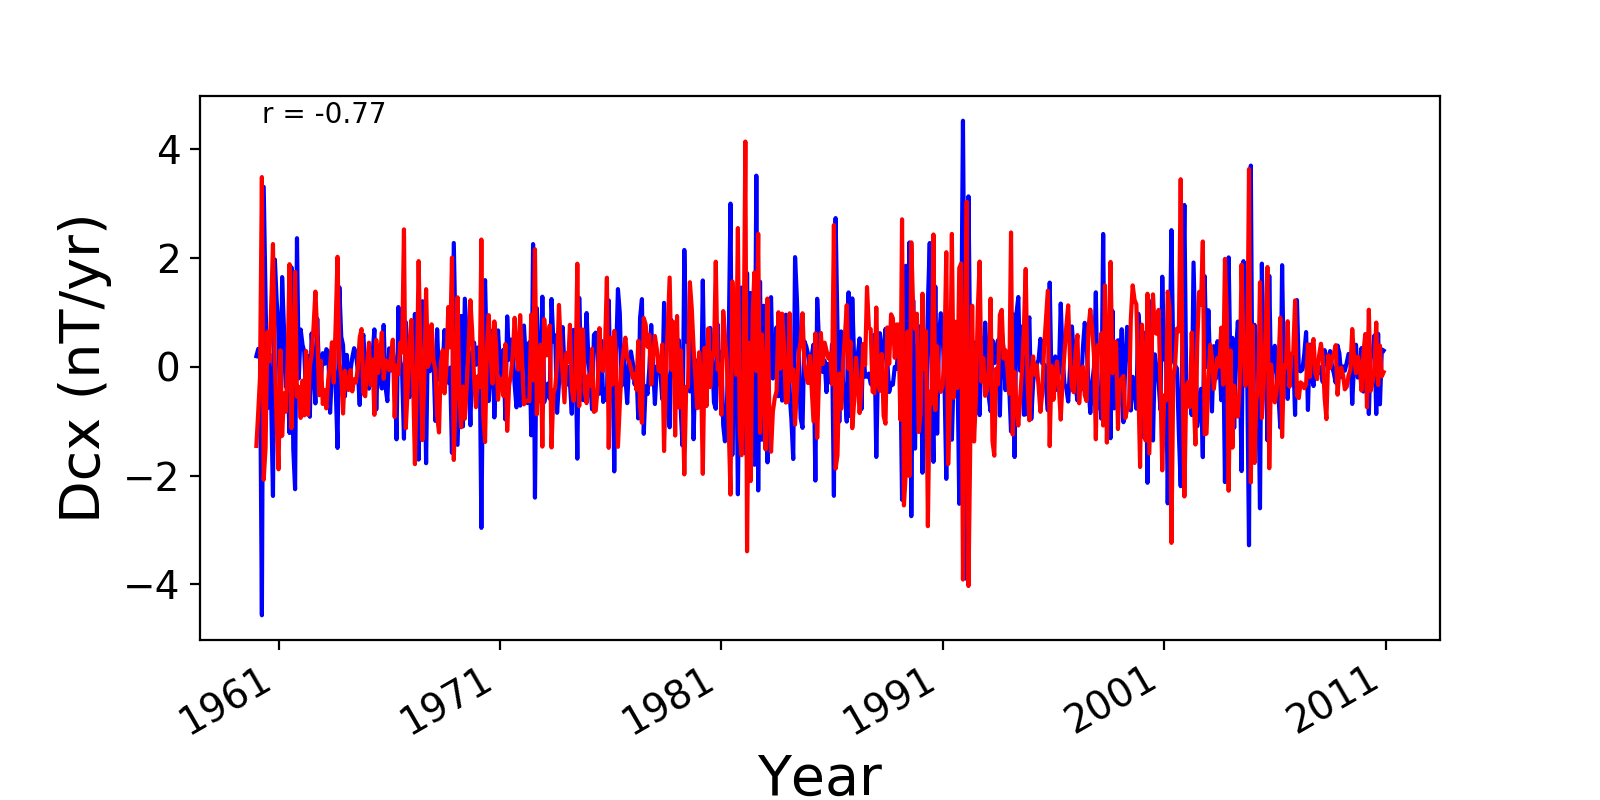

masked_array(data = [18.472608064516013 30.893139599555287 26.16400717463829
 -422.98782763440863 306.935643763441 111.70366123655886 -70.47388865591391
 23.14841774193553 -57.30994075268789 -219.73315118279638 183.1300828494627
 112.40988327957017 70.9139129032258 -118.49416987327206 153.1877956797233
 63.65775134408617 -33.766644892473124 -21.90616010752681
 -112.47232053763426 169.98558387096753 -139.79291499999994
 -208.19392532258053 219.49208698924699 -19.533441827956906
 63.877974193548496 37.53049239631337 26.440920506912487 -54.1972702688173
 19.02920252688176 -84.75445252688165 57.36255252688174
 -0.12478064516152898 -61.99191354838703 82.3132877419355
 -13.450119408602061 -19.644101559139813 23.57243870967741
 5.5277359447003365 30.382844700460968 24.769515537634355 -77.908505860215
 -9.588200806451523 -0.2724701612903928 -30.25481612903225
 -137.8958320430109 135.89302075268841 51.73220258064493 37.567310322580745
 -49.95680000000005 20.678459677419365 -20.778832258064448
 

In [33]:
svplots.plot_dcx(dcx_file=dcx_file,dates=denoised.date, signal=proxy, fig_size=(8, 4), font_size=14, label_size=20, plot_legend=True,
                save_fig=False, write_path=fig_path)

In [35]:
import numpy as np
import os
import pandas as pd
import scipy as sp
import datetime as dt
import matplotlib.pyplot as plt

In [36]:
dcx_file='/Users/gracecox/Desktop/DataDownloads/dcx_fdmm.csv'

In [37]:
col_names = ['date', 'dcx']
dcx = pd.read_csv(dcx_file, names=col_names,
                  dtype={'date': 'str', 'dcx': 'float'}, parse_dates=[0],
                  skiprows=1, index_col=None)

In [38]:
dcx

,date,dcx
0,1957-02-01,166.530665
1,1957-03-01,-20.008070
2,1957-04-01,-48.959408
3,1957-05-01,121.473014
4,1957-06-01,-116.657812
5,1957-07-01,-19.517275
6,1957-08-01,65.784294
7,1957-09-01,-593.041896
8,1957-10-01,543.992383
9,1957-11-01,-37.386738


In [ ]:
t.to_csv(dcx_file, index=False)

In [ ]:
dcx_fdmm

In [ ]:
dcx_fdmm = svtools.calculate_sv_index(dcx, mean_spacing=12)

In [ ]:
dcx_fdmm.to_csv('/Users/gracecox/Desktop/DataDownloads/dcx_admm_decimal.csv', index=False)

In [ ]:
dcx_fdmm['date'] = dcx_fdmm['date'].apply(inputoutput.datetime_to_decimal)

In [ ]:
pred = inputoutput.covobs_readfile(fname="/Users/gracecox/Dropbox/cov-obs_x1/monthly_vals/sv_ngk.dat", data_type='sv')

In [ ]:
pred['date'] = pred['date'].apply(lambda dt: dt.replace(day=15))

In [ ]:
col_names = ['date', 'dcx']
dcx = pd.read_csv(dcx_file, names=col_names,
                  dtype={'date': 'str', 'dcx': 'float'}, parse_dates=[0],
                  skiprows=1)
#   dcx['date'] = dcx['date'].apply(lambda dt: dt.replace(day=1))
# Only keep Dcx data for dates during the period of interest
#dcx = dcx[dcx['date'].isin(dates)]

In [ ]:
pred['date'] = pred['date'].apply(inputoutput.datetime_to_decimal)

In [ ]:
sv = inputoutput.read_csv_data(fname="/Users/gracecox/Desktop/DataDownloads/monthly_sv/fdmm/NGK.csv", data_type='sv')

In [ ]:
def plot_dcx(*, dcx_file, dates, signal, fig_size=(8, 6), font_size=12,
             label_size=16, plot_legend=True, save_fig=False, write_path=None):
    """Compare the proxy used to denoise the SV data with the Dst index.

    Loads Dcx data (extended, corrected Dst) and plots it alongside the signal
    used as a proxy for unmodelled external signal. Both time series are
    reduced to zero mean and unit variance (i.e. their zscore) for plotting.

    Args:
        dates (datetime.datetime): dates of time series measurements.
        dcx_file (str): path to the file containing Dcx data
        signal (time series): proxy for unmodelled external signal used in the
            denoising process (principal component analysis). The proxy is the
            residual in the noisiest eigendirection(s).
        fig_size (array): figure size in inches. Defaults to 8 inches by 6
            inches.
        font_size (int): font size for axes. Defaults to 12 pt.
        label_size (int): font size for axis labels. Defaults to 16 pt.
        plot_legend (bool): option to include a legend on the plot. Defaults
            to True.
    """
    # Read the Dcx data and put into a dataframe
    col_names = ['date', 'dcx']
    dcx = pd.read_csv(dcx_file, names=col_names,
                      dtype={'date': 'str', 'dcx': 'float'}, parse_dates=[0],
                      skiprows=1)
 #   dcx['date'] = dcx['date'].apply(lambda dt: dt.replace(day=1))
    # Only keep Dcx data for dates during the period of interest
    dcx = dcx[dcx['date'].isin(dates)]

    masked_dcx = np.ma.array(dcx['dcx'],
                             mask=np.isnan(dcx['dcx']))
    coeff = np.ma.corrcoef(masked_dcx, signal, rowvar=False,
                           allow_masked=True)

    # Plot the zscore of the two time series
    plt.figure(figsize=fig_size)
    plt.gca().xaxis_date()
    plt.plot(dcx.date, sp.stats.mstats.zscore(dcx.dcx), 'b',
             dates, sp.stats.mstats.zscore(signal), 'r')
    plt.gcf().autofmt_xdate()
    plt.axis('tight')
    plt.xlabel('Year', fontsize=label_size)
    plt.ylabel('Dcx (nT/yr)', fontsize=label_size)
    plt.xticks(fontsize=font_size)
    plt.yticks(fontsize=font_size)
    plt.annotate('r = ' + "{:.2f}".format(coeff.data[0, 1]), xy=(0.05, 0.95),
                 xycoords='axes fraction')
    if plot_legend is True:
        plt.legend(['Dcx', 'proxy'], loc='upper right', frameon=False)
    if save_fig is True:
        fpath = write_path + 'dcx_comparison.pdf'
        plt.savefig(fpath, bbox_inches='tight')
        plt.close()
    return masked_dcx


In [39]:
df = pd.DataFrame({'date': dates, 'proxy': proxy})

In [40]:
# Merge the two dataframes so that only dates contained within both are
    # retained
merged = pd.merge(df, dcx, on='date', how='inner')

In [ ]:
dcx[dcx['date'].isin(dates)]

In [ ]:
merged

In [ ]:
dates

In [ ]:
col_names = ['date', 'dcx']
dcx = pd.read_csv(dcx_file, names=col_names, dtype={'date': 'str', 'dcx': 'float'},parse_dates=[0],skiprows=1)
   # dcx['date'] = dcx['date'].apply(lambda dt: dt.replace(day=1))
    # Only keep Dcx data for dates during the period of interest
#dcx = dcx[dcx['date'].isin(dates)]

In [ ]:
masked_dcx = np.ma.array(dcx['dcx'],
                             mask=np.isnan(dcx['dcx']))

In [ ]:
signal=proxy

In [42]:
from scipy.stats.stats import pearsonr   
a = [1,4,6]
b = [1,2,3]   
print(pearsonr(a,b))

(0.99339926779878274, 0.073186395040328034)


In [43]:
pearsonr(merged.proxy, merged.dcx)

(-0.77284216471651546, 1.3959062829462054e-122)

In [44]:
coeff = np.corrcoef(merged.proxy, merged.dcx)

In [ ]:
coeff = np.ma.corrcoef(masked_dcx, signal, rowvar=False,
                           allow_masked=True)

In [ ]:
dcx.info()

In [46]:
coeff[0,1]

-0.77284216471651568

In [ ]:
df = pd.DataFrame({'proxy': signal, 'dcx': dcx.dcx})

In [ ]:
merged.corr(method='spearman')

In [ ]:
print(max(np.correlate(signal, dcx.dcx,'full')/(np.ma.std(signal)*np.ma.std(dcx.dcx))))

In [ ]:
plt.xcorr(proxy, dcx.dcx, normed=True)

Look at the DFT of the proxy signal and Dcx index

In [ ]:
svplots.plot_dcx_fft(dcx_file=dcx_file, dates=denoised.date, signal=proxy, fig_size=(10, 10), font_size=16, label_size=20,
                     plot_legend=True, save_fig=False,
                     write_path=fig_path)

Plot the eigenvalues of the covariance matrix of the residuals

In [ ]:
svplots.plot_eigenvalues(values=eigenvals, font_size=12, label_size=16, fig_size=(10, 4), save_fig=True,
                        write_path=fig_path)

Plot the eigenvectors corrresponding to the largest eigenvalue(s)

In [ ]:
svplots.plot_eigenvectors(obs_names=obs_names, eigenvecs=eigenvecs, save_fig=True,
                          write_path=fig_path)

# Write denoised data to file

In [ ]:
#for observatory in obs_names:
#    print(observatory)
#    sv_data=denoised.filter(regex=observatory)
#    sv_data.insert(0, 'date', dates)
#    sv_data.columns = ["date", "dX", "dY", "dZ"]
#    inputoutput.write_csv_data(data=sv_data, write_path="/Users/gracecox/Desktop/DataDownloads/denoised_sv/data/",
#                               obs_name=observatory, decimal_dates=True)